In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 8.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

# For modeling the stocks
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler, QuantileTransformer

import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, t

# Import dart APIs
from darts import TimeSeries
from darts.models import TFTModel, MovingAverage
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.metrics import mape, mse, r2_score
from darts.utils.losses import MAELoss, MapeLoss
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# For time stamps
from datetime import datetime, timedelta

plt.style.use("fivethirtyeight")
%matplotlib inline


### Predicting the closing price of Bitcoin:

### Checking Data

In [3]:
# Get the stock quote
df2020 = pd.read_csv('../input/bitcoin-minutes/BTCUSDT_Binance_futures_2020_minute.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'], skiprows=1)
df2021 = pd.read_csv('../input/bitcoin-minutes/BTCUSDT_Binance_futures_2021_minute.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'], skiprows=1)
df2022 = pd.read_csv('../input/bitcoin-minutes/BTCUSDT_Binance_futures_2022_minute.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'], skiprows=1)
#invert dataframes and sort by dates
df2020 = df2020.reindex(index=df2020.index[::-1])
df2021 = df2021.reindex(index=df2021.index[::-1])
df2022 = df2022.reindex(index=df2022.index[::-1])
# Combine three dataframe together
frames = [df2020, df2021, df2022]
df = pd.concat(frames)
# Show the data
df

,open,high,low,close,Volume USDT
date,,,,,
2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,5.091458e+05
2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,7.135396e+05
2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,4.977934e+05
2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,6.986274e+05
2020-01-01 00:05:00,7174.71,7177.14,7173.28,7175.61,2.419795e+05
...,...,...,...,...,...
2022-08-27 00:12:00,20177.00,20197.20,20171.40,20172.80,8.075819e+06
2022-08-27 00:13:00,20172.80,20172.80,20137.70,20144.10,1.186279e+07
2022-08-27 00:14:00,20144.10,20201.60,20136.60,20183.60,4.270755e+07


In [4]:
# Checking data
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
dtype: int64

In [5]:
# remove timezone
df.index = df.index.tz_localize(None)
df.shape

(1391310, 5)

In [6]:
# Slicing data for faster training
# Slicing rows in data frame
df = df.loc['2021-8-19':]

# data frame after slicing
df

,Open,High,Low,Close,Volume USDT
date,,,,,
2021-08-19 00:00:00,44714.09,44775.7,44708.00,44740.11,2.132366e+07
2021-08-19 00:01:00,44740.12,44786.0,44721.00,44774.43,1.346668e+07
2021-08-19 00:02:00,44775.03,44830.7,44750.58,44828.71,2.948076e+07
2021-08-19 00:03:00,44828.71,44830.0,44782.83,44789.98,1.743821e+07
2021-08-19 00:04:00,44789.99,44875.0,44789.34,44858.81,1.455119e+07
...,...,...,...,...,...
2022-08-27 00:12:00,20177.00,20197.2,20171.40,20172.80,8.075819e+06
2022-08-27 00:13:00,20172.80,20172.8,20137.70,20144.10,1.186279e+07
2022-08-27 00:14:00,20144.10,20201.6,20136.60,20183.60,4.270755e+07


In [7]:
df['Return'] = df['Close'].pct_change()
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Volume USDT,Return
date,,,,,,
2021-08-19 00:00:00,44714.09,44775.7,44708.00,44740.11,2.132366e+07,NaN
2021-08-19 00:01:00,44740.12,44786.0,44721.00,44774.43,1.346668e+07,0.000767
2021-08-19 00:02:00,44775.03,44830.7,44750.58,44828.71,2.948076e+07,0.001212
2021-08-19 00:03:00,44828.71,44830.0,44782.83,44789.98,1.743821e+07,-0.000864
2021-08-19 00:04:00,44789.99,44875.0,44789.34,44858.81,1.455119e+07,0.001537
...,...,...,...,...,...,...
2022-08-27 00:12:00,20177.00,20197.2,20171.40,20172.80,8.075819e+06,-0.000203
2022-08-27 00:13:00,20172.80,20172.8,20137.70,20144.10,1.186279e+07,-0.001423
2022-08-27 00:14:00,20144.10,20201.6,20136.60,20183.60,4.270755e+07,0.001961


In [8]:
# Checking data
df.isna().sum()
# first row has a NA return. I set it to 0 manually
df = df.fillna(0)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
Return         0
dtype: int64

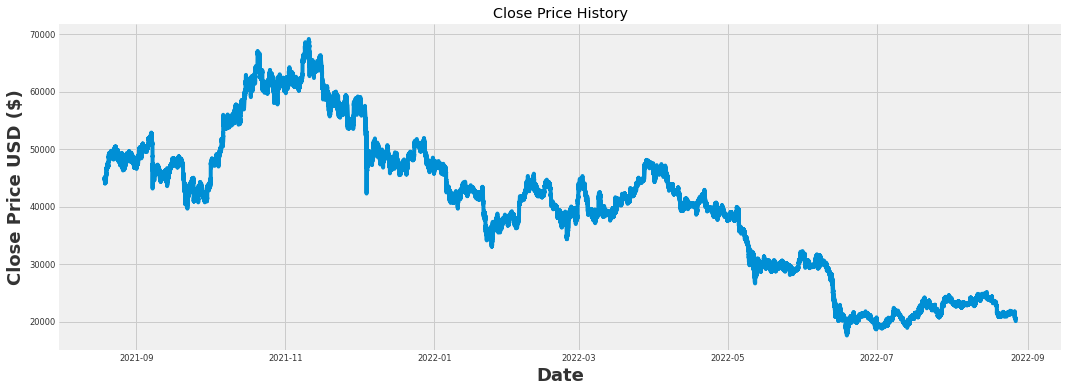

In [11]:
# Plot close price history
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
#plt.hist(df['Volume']);
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

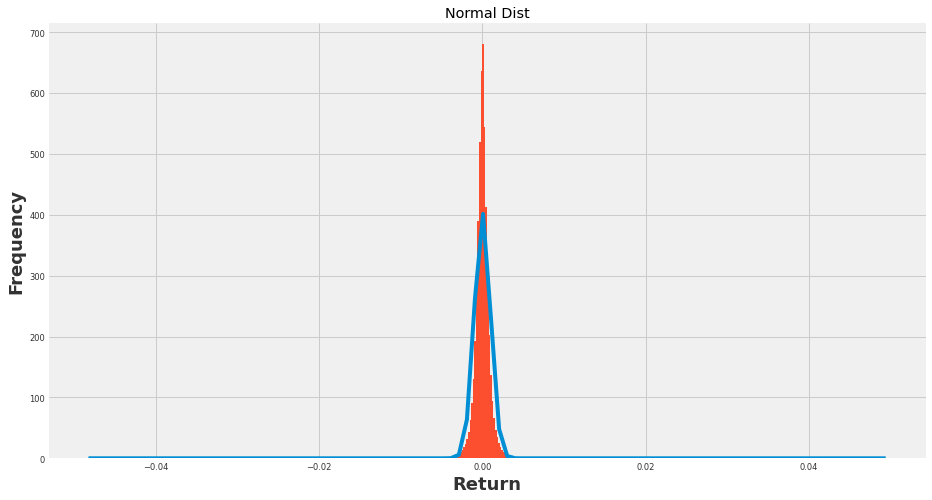

In [12]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

y_list = norm.pdf(x_list, loc=df['Return'].mean(), scale=df['Return'].std())

plt.figure(figsize=(14,8))
plt.title('Normal Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

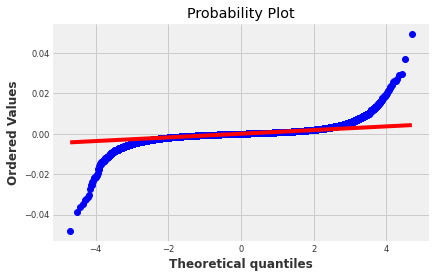

In [13]:
probplot(df['Return'],dist='norm',fit= True,plot=plt);

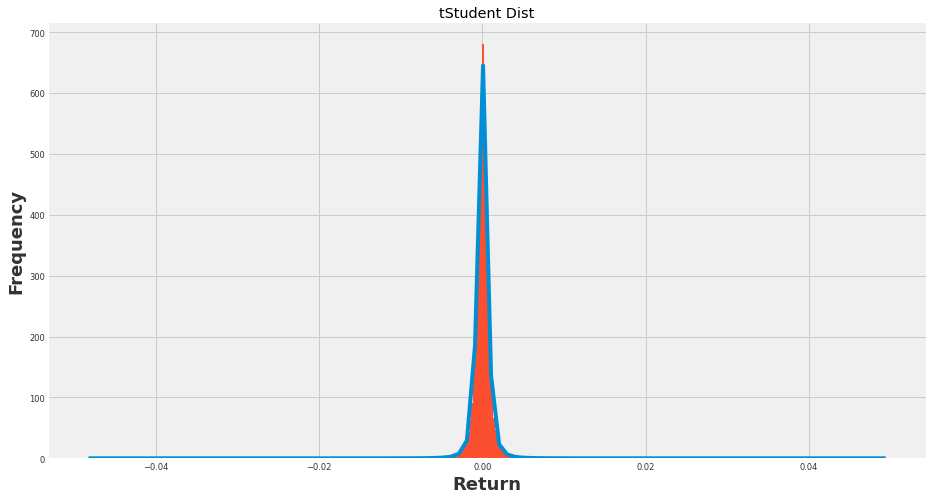

In [14]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

params = t.fit(df['Return'].dropna())
degree_of_freedom, loc, scale = params

y_list = t.pdf(x_list, degree_of_freedom, loc, scale)

plt.figure(figsize=(14,8))
plt.title('tStudent Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

### Processing data

In [15]:
# features list
features = ['Close']
feature_size = len(features)
feature_size

1

In [16]:
# Create a new dataframe with only the 'Close' and 'volume' column 
df = df.filter(features)
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Close
date,
2021-08-19 00:00:00,44740.11
2021-08-19 00:01:00,44774.43
2021-08-19 00:02:00,44828.71
2021-08-19 00:03:00,44789.98
2021-08-19 00:04:00,44858.81
...,...
2022-08-27 00:12:00,20172.80
2022-08-27 00:13:00,20144.10
2022-08-27 00:14:00,20183.60


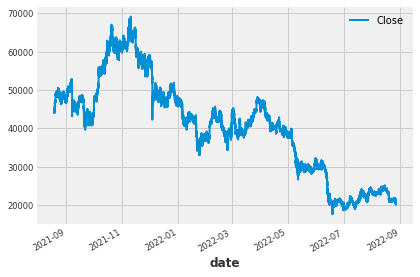

In [17]:
#bh = pd.tseries.offsets.BusinessHour(start='9:30', end='15:30')
data = TimeSeries.from_dataframe(df, fill_missing_dates=True, freq='min')
data.plot()

### Smoothing data

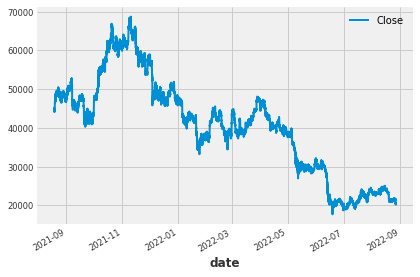

In [18]:
moving = MovingAverage(window=15)
smooth_data = moving.filter(data)
smooth_data.plot()

In [19]:
# Get the number of rows to train the model on (90% of total data)
x_train, x_test = smooth_data.split_before(0.9)
print(x_train.n_timesteps)
print(x_test.n_timesteps)

483422
53715


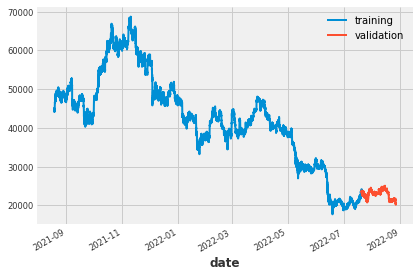

In [20]:
x_train.plot(label="training")
x_test.plot(label="validation")

In [21]:
# Pipeline
scaler1 = RobustScaler()
scaler2 = MinMaxScaler()
pipeline = Pipeline([Scaler(scaler1),  Scaler(scaler2)])
rescaled_train = pipeline.fit_transform(x_train)
rescaled_test = pipeline.transform(x_test)
rescaled_data = pipeline.transform(smooth_data)

In [22]:
print('All data end time: ' + str(rescaled_data.end_time()))
print('Train data end time: ' + str(rescaled_train.end_time()))
print('Test data end time: ' + str(rescaled_test.end_time()))

All data end time: 2022-08-27 00:16:00
Train data end time: 2022-07-20 17:01:00
Test data end time: 2022-08-27 00:16:00


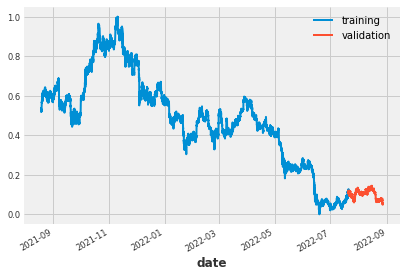

In [23]:
rescaled_train.plot(label="training")
rescaled_test.plot(label="validation")

### Building Model using Temporal Fusion Transformer (TFT)

#### Callbacks

In [24]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopping_callback = EarlyStopping(
                                        monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0005,
                                        mode='min',
                                        )

# saves a file like: my/path/epoch=2-val_loss=0.02-other_metric=0.03.ckpt
model_checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                            save_top_k=5,
                                            dirpath='saved_model',
                                            filename='{epoch}-{val_loss:.2f}-{other_metric:.2f}',
                                            )

lr_monitor = LearningRateMonitor(logging_interval='step')

### Create covariate

In [25]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# create year, month and integer index covariate series
training_cutoff = pd.Timestamp(rescaled_train.end_time())
covariates = datetime_attribute_timeseries(smooth_data, attribute='hour', one_hot=False)

covariates = covariates.stack(
    datetime_attribute_timeseries(smooth_data, attribute='minute', one_hot=False)
)

covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=smooth_data.time_index,
        values=np.arange(len(smooth_data)),
        columns=['linear_increase'],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [26]:
encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['absolute'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}

# default quantiles for QuantileRegression
quantiles = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
input_chunk_length = 60
forecast_horizon = 15
tft_model = TFTModel(
    model_name='TFTModel',
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=100,
    lstm_layers=1,
    num_attention_heads=8,
    dropout=0,
    batch_size=160,
    n_epochs=25,
    add_relative_index=False,
    #add_encoders=encoders,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    #loss_fn=MAELoss(),
    pl_trainer_kwargs={'accelerator': 'gpu', 'auto_select_gpus': True},
    force_reset=True,
    save_checkpoints=True,
    log_tensorboard=True,
)

In [27]:
model = tft_model.fit(rescaled_train, val_series=rescaled_test, future_covariates=covariates_transformed, val_future_covariates=covariates_transformed, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [34]:
# Saves only on the main process
model.save_model('epoch24.ckpt')

In [35]:
# load the model state that performed best on validation set
best_model = model.load_from_checkpoint(model_name='TFTModel', best=True)

In [36]:
best_model.save_model('best_model.ckpt')

In [37]:
# before starting, we define some constants
num_samples = 500

figsize = (10, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [40]:
def eval_model(model_name, forecast_horizon, actual_series, val_series):
    pred_series = model.predict(n=forecast_horizon, num_samples=num_samples, future_covariates=covariates_transformed, mc_dropout=True)

    # Rescale data to real value (Inverse transform)
    pred_series = pipeline.inverse_transform(pred_series)
    actual_series = pipeline.inverse_transform(actual_series)
    val_series = pipeline.inverse_transform(val_series)

    # plot actual series
    plt.figure(figsize=figsize)
    end = pred_series.end_time()
    start = end - timedelta(hours=1)
    data[start : end].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    # Plot title
    plt.title('MAPE: {:.2f}%'.format(mape(val_series, pred_series)))
    plt.legend()

Predicting: 3021it [00:00, ?it/s]

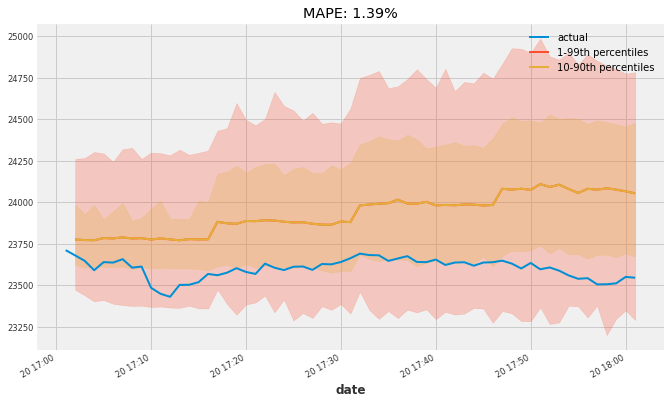

In [41]:
prediction = eval_model(best_model, 60, rescaled_data, rescaled_test)